In [1]:
import time
start_time = time.time()
import pandas as pd
#import dask.dataframe as pd
import numpy as np
import xgboost as xgb
import re
import matplotlib.pyplot as plt
from datetime import datetime as dt
from datetime import timedelta as td

import seaborn as sns

from tqdm._tqdm_notebook import tqdm_notebook
from warnings import filterwarnings

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

#from keras import Sequential
#from keras.layers import Dense
m = "test"

%matplotlib inline
filterwarnings('ignore')

tqdm_notebook.pandas(desc="Progress:")

<ipython-input-1-87c762a3288b>:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`
  from tqdm._tqdm_notebook import tqdm_notebook


In [2]:
# Считываем данные
tr_mcc_codes = pd.read_csv('../data/tr_mcc_codes.csv', sep=';', index_col='mcc_code')
tr_types = pd.read_csv('../data/tr_types.csv', sep=';', index_col='tr_type')

transactions = pd.read_csv('../data/transactions.csv', index_col='customer_id')
gender_train = pd.read_csv('../data/gender_train.csv', index_col='customer_id')
gender_test = pd.read_csv('../data/gender_test.csv', index_col='customer_id')
transactions_train = transactions.join(gender_train, how='inner')
transactions_test = transactions.join(gender_test, how='inner')

del transactions

In [3]:
# Функции, которыми можно пользоваться для построения классификатора, 
# оценки его результатов и построение прогноза для тестовой части пользователей

# Cross-validation score (среднее значение метрики ROC AUC на тренировочных данных)
def cv_score(params, train, y_true):
    cv_res=xgb.cv(params, xgb.DMatrix(train, y_true, silent = True),
                  early_stopping_rounds=10, maximize=True, 
                  num_boost_round=(10000), nfold=5, stratified=True)
    index_argmax = cv_res['test-auc-mean'].argmax()
    #print('Cross-validation, ROC AUC: {:.3f}+-{:.3f}, Trees: {}'.format(cv_res.loc[index_argmax]['test-auc-mean'],
    #                                                                    cv_res.loc[index_argmax]['test-auc-std'],
    #                                                                    index_argmax))
    return round(cv_res.loc[index_argmax]['test-auc-mean'], 4)

# Построение модели + возврат результатов классификации тестовых пользователей
def fit_predict(params, num_trees, train, test, target):
    params['learning_rate'] = params['eta']
    clf = xgb.train(params, xgb.DMatrix(train.values, target, feature_names=list(train.columns)), 
                    num_boost_round=num_trees, maximize=True)
    y_pred = clf.predict(xgb.DMatrix(test.values, feature_names=list(train.columns)))
    submission = pd.DataFrame(index=test.index, data=y_pred, columns=['probability'])
    return clf, submission

# Отрисовка важности переменных. Важность переменной - количество разбиений выборки, 
# в которых участвует данная переменная. Чем больше - тем она, вероятно, лучше 
def draw_feature_importances(clf, top_k=10):
    plt.figure(figsize=(10, 10))
    
    importances = dict(sorted(clf.get_score().items(), key=lambda x: x[1])[-top_k:])
    y_pos = np.arange(len(importances))
    
    plt.barh(y_pos, list(importances.values()), align='center', color='green')
    plt.yticks(y_pos, importances.keys(), fontsize=12)
    plt.xticks(fontsize=12)
    plt.xlabel('Feature importance', fontsize=15)
    plt.title('Features importances, Sberbank Gender Prediction', fontsize=18)
    plt.ylim(-0.5, len(importances) - 0.5)
    plt.show()

In [4]:
transactions_test["ind_day"] = transactions_test.tr_datetime.apply(lambda x: int(x.split()[0]))
transactions_train["ind_day"] = transactions_train.tr_datetime.apply(lambda x: int(x.split()[0]))
transactions_test["real_amount"] = transactions_test.amount.apply(lambda x: int(x) / (np.pi ** np.e))
transactions_train["real_amount"] = transactions_train.amount.apply(lambda x: int(x) / (np.pi ** np.e))
transactions_test["real_date"] = transactions_test.ind_day.apply(lambda x: dt(2018,1,1) + td(days=(int(x)-153)))
transactions_train["real_date"] = transactions_train.ind_day.apply(lambda x: dt(2018,1,1) + td(days=(int(x)-153)))
transactions_test["hour"] = transactions_test.tr_datetime.apply(lambda x: int(x.split()[1].split(":")[0]))
transactions_train["hour"] = transactions_train.tr_datetime.apply(lambda x: int(x.split()[1].split(":")[0]))

for df in [transactions_train, transactions_test]:
    df['day'] = df['tr_datetime'].str.split().apply(lambda x: int(x[0]) % 7)
    df['hour'] = df['tr_datetime'].apply(lambda x: re.search(' \d*', x).group(0)).astype(int)
    df['night'] = ~df['hour'].between(6, 22).astype(int)

<div style="background:#f00;color:#fff;padding:10px;text-align:center"><h2>Создание фичей</h2></div>

In [5]:
def my_features(x): 
    features = []

    features.append(pd.Series(data=x[(x['amount'] < 0)]['amount'].agg(['mean'])\
                              .add_prefix('amount_')))       
    
    return pd.concat(features)

data_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features).unstack(-1)
data_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features).unstack(-1)

In [6]:
data_train = data_train.unstack().T
data_test = data_test.unstack().T

<div style="background:#fc0">Праздники</div>

In [7]:
def my_features(x): 
    features = []

    features.append(pd.Series(data=x[(x['amount']<0) & (x['mcc_code']==5992) & 
                              (x['real_date'] <= dt(2018,3,8)) & (x['real_date'] >= dt(2018,3,6))]['amount']\
                              .agg(['sum']).add_prefix('5992_')))  

    features.append(pd.Series(data=x[(x['amount']<0) & (x['mcc_code']==5944) & 
                              (x['real_date'] <= dt(2018,3,8)) & (x['real_date'] >= dt(2018,3,6))]['amount']\
                              .agg(['sum']).add_prefix('5944_'))) 

    features.append(pd.Series(data=x[(x['amount']<0) & (x['mcc_code']==5611) & 
                              (x['real_date'] <= dt(2018,2,23)) & (x['real_date'] >= dt(2018,2,18))]['amount']\
                              .agg(['sum']).add_prefix('5611_')))  

    features.append(pd.Series(data=x[(x['amount']<0) & (x['mcc_code']==5947) & 
                              (x['real_date'] <= dt(2018,2,23)) & (x['real_date'] >= dt(2018,2,18))]['amount']\
                              .agg(['sum']).add_prefix('5947_')))      
    
    return pd.concat(features)


new_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features).unstack(-1)
new_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features).unstack(-1)
data_train = pd.merge(data_train, new_train.unstack().T, left_index=True, right_index=True)
data_test = pd.merge(data_test, new_test.unstack().T, left_index=True, right_index=True)


<div style="background:#fc0">TOP20 tr_type</div>

In [8]:
def my_features(x): 
    features = []
    
    tr_types = [6210, 8100, 7075, 1310, 7034, 1410, 6200, 7014, 7074, 6010, 4041,
            2460, 7040, 4210, 2320, 4020, 6100, 7030, 2440, 7071]
    features.append(pd.Series(data=map(lambda y: x[x.tr_type == y]['amount'].count(), tr_types),
                              index=tr_types).add_prefix('tr_type_20_'))
    
    return pd.concat(features)

new_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features).unstack(-1)
new_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features).unstack(-1)
data_train = pd.merge(data_train, new_train.unstack().T, left_index=True, right_index=True)
data_test = pd.merge(data_test, new_test.unstack().T, left_index=True, right_index=True)

<div style="background:#fc0">TOP mcc_code</div>

In [9]:
def my_features(x): 
    features = []
    
    mcc_codes = [5967, 5965, 6211, 5931, 7995, 7994, 4784, 7512, 7993, 5940, 3501,
            5621, 5949, 5532, 5013, 5533, 5631, 7538, 5714, 5977, 6051, 5511,
             742, 7542, 5733, 7372, 4214, 7933, 5816, 5541, 5045, 5651, 5065,
            7011, 5734, 5699, 5462, 7278, 5661, 8398, 5691, 5964]
    features.append(pd.Series(data=map(lambda y: x[x.mcc_code == y]['amount'].count(), mcc_codes),
                              index=mcc_codes).add_prefix('mcc_code_'))
    
    return pd.concat(features)

new_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features).unstack(-1)
new_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features).unstack(-1)
data_train = pd.merge(data_train, new_train.unstack().T, left_index=True, right_index=True)
data_test = pd.merge(data_test, new_test.unstack().T, left_index=True, right_index=True)

<div style="background:#fc0">Default</div>

In [10]:
def my_features(x): 
    features = []
    
    features.append(pd.Series(x['day'].value_counts(normalize=True).add_prefix('day_')))
    features.append(pd.Series(x['hour'].value_counts(normalize=True).add_prefix('hour_')))
    features.append(pd.Series(x['night'].value_counts(normalize=True).add_prefix('night_')))
    features.append(pd.Series(x[x['amount']>0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('positive_transactions_')))
    features.append(pd.Series(x[x['amount']<0]['amount'].agg(['min', 'max', 'mean', 'median', 'std', 'count'])\
                                                        .add_prefix('negative_transactions_')))
    
    return pd.concat(features)

new_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features).unstack(-1)
new_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features).unstack(-1)

data_train = pd.merge(data_train, new_train, left_index=True, right_index=True)
data_test = pd.merge(data_test, new_test, left_index=True, right_index=True)
    

<div style="background:#fc0">mcc codes stat</div>

In [11]:
def my_features(x): 
    features = []
    
    mcc = {
        'min': [4814, 6010, 5977, 5812, 5200, 5945, 4900, 5211, 5411, 5814, 5735, 5541, 5311, 5641, 4829, 5499],
        'std': [5814, 5311, 5735, 5541, 5641, 4829, 5211],
        'count': [5977, 5691, 5661, 4112, 5912, 4814, 6010, 5541, 5211, 5921],
        'sum': [5541, 5921, 5812, 5735, 6011, 6010, 4829, 5814, 5977, 5661, 5912],
        'median': [8999, 4829, 4112, 5211],
     }
    
    for i in mcc:
        for n in mcc[i]:
            features.append(pd.Series(data=x[(x['amount']<0) & (x['mcc_code']==n)]['amount'].agg([i])\
                                      .add_prefix(str(n)+'_')))
    
    return pd.concat(features)

new_train = transactions_train.groupby(transactions_train.index)\
                               .progress_apply(my_features).unstack(-1)
new_test = transactions_test.groupby(transactions_test.index)\
                             .progress_apply(my_features).unstack(-1)
data_train = pd.merge(data_train, new_train.unstack().T, left_index=True, right_index=True)
data_test = pd.merge(data_test, new_test.unstack().T, left_index=True, right_index=True)

<div style="background:#f00;color:#fff;padding:10px;text-align:center"><h2>Подготовка данных</h2></div>

In [12]:
data_train_g = data_train.join(gender_train, how='inner')

In [13]:
features = list(data_train_g.columns)

#features = features[5:]

my_data_train_g = data_train_g[features[:]]
my_data_train = data_train[features[:-1]]
my_data_test = data_test[features[:-1]]

#for i in features[:-1]:
#    my_data_train_g[i] = my_data_train_g[i].map(lambda x: 1 if x > 0 else 0)
#    my_data_train[i] = my_data_train[i].map(lambda x: 1 if x > 0 else 0)
#    my_data_test[i] = my_data_test[i].map(lambda x: 1 if x > 0 else 0)
    

In [14]:
my_data_train_g.to_csv("my_data_train_g.csv")
my_data_train.to_csv("my_data_train.csv")
my_data_test.to_csv("my_data_test.csv")

In [15]:
my_data_train_g = pd.read_csv("my_data_train_g.csv")
my_data_train = pd.read_csv("my_data_train.csv")
my_data_test = pd.read_csv("my_data_test.csv")

In [16]:
Y = list(my_data_train_g.iloc[:, len(features)-1])
sc = StandardScaler()
X = sc.fit_transform(my_data_train.fillna(0))


#X, X_test, Y, y_test = train_test_split(X, Y, test_size=0.3)

<div style="background:#f00;color:#fff;padding:10px;text-align:center"><h2>XGBoost</h2></div>

In [17]:
"""target = my_data_train_g['gender']

m = 0
best_param = {}

for min_child_weight in [0, 1, 3, 5, 7, 10]:
    for gamma in [0, 0.1, 0.5, 1, 1.5, 2, 5]:
        for subsample in [0.5, 0.6, 0.8, 1.0]:
            for colsample_bytree in [0.6, 0.7, 0.8, 0.9, 1.0]:
                for max_depth in [3, 4, 6, 10]:
                    for eta in [0.01, 0.05, 0.1, 0.2]:
                        for lambda_ in [0.5, 0.7, 1.0]:
                            for alpha in [0.0, 0.1, 0.2, 0.5, 0.7]:

                                params_xb = {
                                    'eta': eta,
                                    'max_depth': max_depth, #3,
                                    'subsample': subsample, #0.8,
                                    'colsample_bytree': colsample_bytree, #0.8,

                                    'gamma': gamma, #0,
                                    'lambda': lambda_,
                                    'alpha': alpha,
                                    'min_child_weight': min_child_weight, #0,

                                    'eval_metric': 'auc',
                                    'objective': 'binary:logistic' ,
                                    'booster': 'gbtree',
                                    #'njobs': -1,
                                    #'tree_method': 'approx',
                                    'tree_method': 'gpu_hist',
                                    'gpu_id': 0
                                }
                                sc = cv_score(params_xb, my_data_train, target)
                                if m < sc:
                                    m = sc
                                    best_param = params_xb
                                    print(m, min_child_weight, gamma, subsample, colsample_bytree, max_depth, eta, lambda_, alpha)
"""
None

In [18]:
#clf, submission = fit_predict(best_param, 70, my_data_train, my_data_test, target)
#draw_feature_importances(clf, 10)

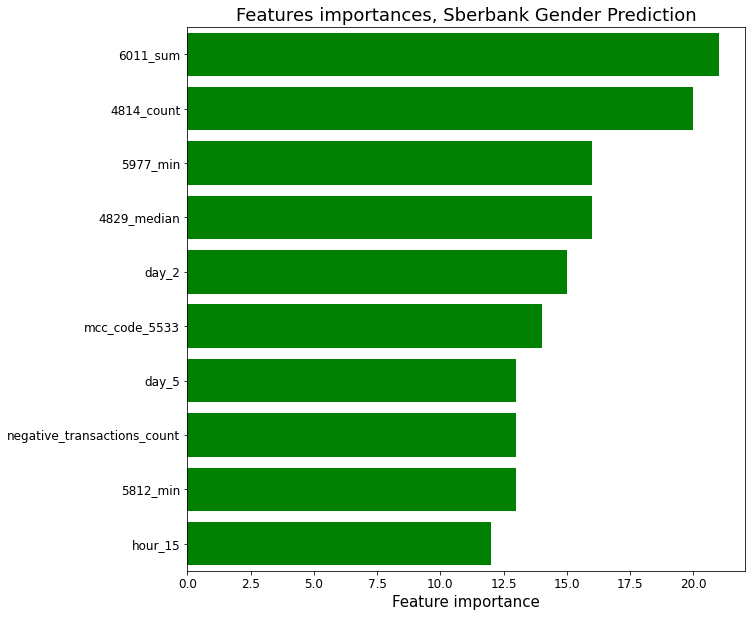

0.8606

In [19]:
params_xb = {
    'eta': 0.3,
    'max_depth': 4, #3,
    'subsample': 0.8, #0.8,
    'colsample_bytree': 0.9, #0.8,

    'gamma': .2, #0,
    'lambda': 0.5,
    'alpha': .5,
    'min_child_weight': 7, #0,

    'eval_metric': 'auc',
    'objective': 'binary:logistic' ,
    'booster': 'gbtree',
    #'njobs': -1,
    #'tree_method': 'approx',
    'tree_method': 'gpu_hist',
    'gpu_id': 0
}
target = my_data_train_g['gender']
sc = cv_score(params_xb, my_data_train, target)
clf, submission = fit_predict(params_xb, 70, my_data_train, my_data_test, target)
draw_feature_importances(clf, 10)
sc

<div style="background:#fc0">Запись результатов</div>

In [20]:
# XGBoost
submission.to_csv(f'../results/submission_xgboost_{m}.csv')

In [21]:
time.time() - start_time, (time.time() - start_time)/60

(1136.2994556427002, 18.93832426071167)

<div style="background:#f00;color:#fff;padding:10px;text-align:center"><h2>Keras</h2></div>

In [22]:
params = [
    {
        "act": "tanh",
        "num": 8
    },
    {
        "act": "tanh",
        "num": 8
    },
    {
        "act": "sigmoid",
        "epoch": 75,
        'batch': 10
    }
]

In [23]:
classifier = Sequential()
#First Hidden Layer
classifier.add(Dense(params[0]['num'], activation=params[0]['act'], kernel_initializer='random_normal', input_dim=(len(features)-1)))
#Second  Hidden Layer
classifier.add(Dense(params[1]['num'], activation=params[1]['act'], kernel_initializer='random_normal'))
#Output Layer
classifier.add(Dense(1, activation=params[2]['act'], kernel_initializer='random_normal'))

classifier.compile(optimizer ='adam',loss='binary_crossentropy', metrics =['accuracy'])

classifier.fit(X, Y, batch_size=params[2]['batch'], epochs=params[2]['epoch'])

Epoch 1/75
8400/8400 [==============================] - ETA: 1:18 - loss: 0.6927 - accuracy: 0.60 - ETA: 2s - loss: 0.6905 - accuracy: 0.6000 - ETA: 1s - loss: 0.6760 - accuracy: 0.65 - ETA: 1s - loss: 0.6578 - accuracy: 0.66 - ETA: 0s - loss: 0.6350 - accuracy: 0.68 - ETA: 0s - loss: 0.6152 - accuracy: 0.69 - ETA: 0s - loss: 0.6037 - accuracy: 0.69 - ETA: 0s - loss: 0.5925 - accuracy: 0.70 - ETA: 0s - loss: 0.5802 - accuracy: 0.71 - ETA: 0s - loss: 0.5759 - accuracy: 0.71 - ETA: 0s - loss: 0.5677 - accuracy: 0.71 - ETA: 0s - loss: 0.5598 - accuracy: 0.72 - ETA: 0s - loss: 0.5548 - accuracy: 0.72 - ETA: 0s - loss: 0.5498 - accuracy: 0.72 - ETA: 0s - loss: 0.5481 - accuracy: 0.72 - ETA: 0s - loss: 0.5448 - accuracy: 0.72 - 1s 103us/step - loss: 0.5443 - accuracy: 0.7296
Epoch 2/75
8400/8400 [==============================] - ETA: 1:20 - loss: 0.3927 - accuracy: 0.80 - ETA: 2s - loss: 0.5014 - accuracy: 0.7509 - ETA: 1s - loss: 0.4978 - accuracy: 0.75 - ETA: 0s - loss: 0.4853 - accuracy:

8400/8400 [==============================] - ETA: 0s - loss: 0.3815 - accuracy: 0.80 - ETA: 0s - loss: 0.4362 - accuracy: 0.78 - ETA: 0s - loss: 0.4376 - accuracy: 0.78 - ETA: 0s - loss: 0.4351 - accuracy: 0.79 - ETA: 0s - loss: 0.4344 - accuracy: 0.78 - ETA: 0s - loss: 0.4280 - accuracy: 0.79 - ETA: 0s - loss: 0.4290 - accuracy: 0.79 - ETA: 0s - loss: 0.4287 - accuracy: 0.79 - ETA: 0s - loss: 0.4321 - accuracy: 0.79 - ETA: 0s - loss: 0.4366 - accuracy: 0.79 - ETA: 0s - loss: 0.4363 - accuracy: 0.79 - ETA: 0s - loss: 0.4367 - accuracy: 0.79 - ETA: 0s - loss: 0.4336 - accuracy: 0.79 - ETA: 0s - loss: 0.4350 - accuracy: 0.79 - ETA: 0s - loss: 0.4369 - accuracy: 0.79 - 1s 86us/step - loss: 0.4366 - accuracy: 0.7979
Epoch 24/75
8400/8400 [==============================] - ETA: 1s - loss: 0.5998 - accuracy: 0.70 - ETA: 0s - loss: 0.4521 - accuracy: 0.78 - ETA: 0s - loss: 0.4574 - accuracy: 0.78 - ETA: 0s - loss: 0.4310 - accuracy: 0.80 - ETA: 0s - loss: 0.4322 - accuracy: 0.80 - ETA: 0s - l

8400/8400 [==============================] - ETA: 1s - loss: 0.1938 - accuracy: 1.00 - ETA: 0s - loss: 0.3965 - accuracy: 0.82 - ETA: 0s - loss: 0.3899 - accuracy: 0.82 - ETA: 0s - loss: 0.3984 - accuracy: 0.81 - ETA: 0s - loss: 0.4084 - accuracy: 0.81 - ETA: 0s - loss: 0.4065 - accuracy: 0.81 - ETA: 0s - loss: 0.4049 - accuracy: 0.81 - ETA: 0s - loss: 0.4090 - accuracy: 0.81 - ETA: 0s - loss: 0.4074 - accuracy: 0.81 - ETA: 0s - loss: 0.4080 - accuracy: 0.81 - ETA: 0s - loss: 0.4090 - accuracy: 0.81 - ETA: 0s - loss: 0.4104 - accuracy: 0.81 - ETA: 0s - loss: 0.4114 - accuracy: 0.81 - ETA: 0s - loss: 0.4113 - accuracy: 0.81 - 1s 83us/step - loss: 0.4128 - accuracy: 0.8119
Epoch 46/75
8400/8400 [==============================] - ETA: 1s - loss: 0.1795 - accuracy: 1.00 - ETA: 0s - loss: 0.4492 - accuracy: 0.79 - ETA: 0s - loss: 0.4267 - accuracy: 0.81 - ETA: 0s - loss: 0.4071 - accuracy: 0.82 - ETA: 0s - loss: 0.4020 - accuracy: 0.82 - ETA: 0s - loss: 0.4065 - accuracy: 0.81 - ETA: 0s - l

Epoch 67/75
8400/8400 [==============================] - ETA: 1s - loss: 0.2358 - accuracy: 0.90 - ETA: 0s - loss: 0.3978 - accuracy: 0.83 - ETA: 0s - loss: 0.3865 - accuracy: 0.84 - ETA: 0s - loss: 0.3880 - accuracy: 0.83 - ETA: 0s - loss: 0.3909 - accuracy: 0.83 - ETA: 0s - loss: 0.3864 - accuracy: 0.83 - ETA: 0s - loss: 0.3877 - accuracy: 0.82 - ETA: 0s - loss: 0.3907 - accuracy: 0.82 - ETA: 0s - loss: 0.3956 - accuracy: 0.82 - ETA: 0s - loss: 0.4002 - accuracy: 0.82 - ETA: 0s - loss: 0.3975 - accuracy: 0.82 - ETA: 0s - loss: 0.3987 - accuracy: 0.82 - ETA: 0s - loss: 0.3951 - accuracy: 0.82 - ETA: 0s - loss: 0.3981 - accuracy: 0.82 - ETA: 0s - loss: 0.3982 - accuracy: 0.82 - 1s 86us/step - loss: 0.3986 - accuracy: 0.8219
Epoch 68/75
8400/8400 [==============================] - ETA: 1s - loss: 0.5073 - accuracy: 0.50 - ETA: 0s - loss: 0.3564 - accuracy: 0.83 - ETA: 0s - loss: 0.3814 - accuracy: 0.81 - ETA: 0s - loss: 0.3881 - accuracy: 0.82 - ETA: 0s - loss: 0.3930 - accuracy: 0.81 -

In [20]:
y_pred = classifier.predict(X_test)
y_pred2 = (y_pred>0.5)

cm = confusion_matrix(y_test, y_pred2)
print(cm)
acc = (cm[0][0] + cm[1][1])/sum(sum(cm))
acc

[[1112  322]
 [ 382  704]]


0.7206349206349206

<div style="background:#fc0">Запись результатов</div>

In [25]:
# Keras
test = sc.fit_transform(my_data_test.fillna(0))
y_pred = classifier.predict(test)
pd.DataFrame(data={'probability':list(y_pred)}, index=my_data_test.index).to_csv('../data/submission_keras.csv')